In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
from teeplot import teeplot as tp


In [2]:
df = pd.read_parquet("https://osf.io/gk2ty/download")


In [3]:
df.columns


Index(['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index',
       'Run ID', 'Is Task Coding Site', 'Is Viability Site',
       'Is Task Coding Site Cumulative Count',
       'Is Viability Site Cumulative Count',
       'Prev Is Task Coding Site Cumulative Count',
       'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site',
       'Prev Is Viability Site', 'Site', 'Has Task', 'has task',
       'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP',
       'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK',
       'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS',
       'Is Task Coding Site Delta', 'Is Viability Site Delta',
       'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count',
       'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK',
       'Generation Born', 'Update Born'],
      dtype='object')

In [4]:
df["Components"] = df["Task"].map(
    {
        "AND": 2,
        "ANDNOT": 3,
        "NAND": 1,
        "NOR": 4,
        "NOT": 1,
        "OR": 3,
        "ORNOT": 2,
        "XOR": 4,
        "EQUALS": 5,
    },
)


In [5]:
df["codes for num tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Is Task Coding Site"].transform("sum")


In [6]:
df["prev codes for num tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Prev Is Task Coding Site"].transform("sum")


In [7]:
df["prev codes for tasks"] = df["prev codes for num tasks"].astype(bool)


In [8]:
df["prev coded for tasks"] = df.groupby(
    ["Site", "Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["Prev Is Task Coding Site Cumulative Count"].transform("sum")
df["prev coded for tasks"] = df["prev coded for tasks"].astype(bool)


In [9]:
df['First Task Generation'] = df['Generation Born'].where(
    df['has task'] != 0,
).groupby(
    [df['Treatment'], df['Run ID'], df['Task']],
    observed=True,
).transform('min')


In [10]:
df["SLIP_INSERTION_BOOL_MASK any"] = df.groupby(
    ["Lineage Generation Index", "Treatment", "Run ID"],
    observed=True,
)["SLIP_INSERTION_BOOL_MASK"].transform("any")


In [11]:
dff = df[
    (df["delta has task"] == 1)
    & (df["Generation Born"] == df["First Task Generation"])
    & (df["Treatment"] == "Slip-duplicate")
    # & df["Is Task Coding Site"]
].reset_index(drop=True)
dff


,Task,Treatment,Genome Length,Lineage Generation Index,Run ID,Is Task Coding Site,Is Viability Site,Is Task Coding Site Cumulative Count,Is Viability Site Cumulative Count,Prev Is Task Coding Site Cumulative Count,...,SLIP_INSERTION_BOOL_MASK,Generation Born,Update Born,Components,codes for num tasks,prev codes for num tasks,prev codes for tasks,prev coded for tasks,First Task Generation,SLIP_INSERTION_BOOL_MASK any
0,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
1,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
2,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
3,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
4,AND,Slip-duplicate,430,47,run_1590,False,True,0,48,0,...,False,260,4010,2,0,0,False,False,260.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81054,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
81055,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
81056,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False
81057,XOR,Slip-duplicate,403,98,run_1619,False,True,0,40,0,...,False,623,8616,4,0,0,False,False,623.0,False


In [12]:
dff.columns


Index(['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index',
       'Run ID', 'Is Task Coding Site', 'Is Viability Site',
       'Is Task Coding Site Cumulative Count',
       'Is Viability Site Cumulative Count',
       'Prev Is Task Coding Site Cumulative Count',
       'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site',
       'Prev Is Viability Site', 'Site', 'Has Task', 'has task',
       'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP',
       'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK',
       'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS',
       'Is Task Coding Site Delta', 'Is Viability Site Delta',
       'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count',
       'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK',
       'Generation Born', 'Update Born', 'Components', 'codes for num tasks',
       'prev codes for num tasks', 'prev codes for tasks',
       'prev coded for tasks', 

teeplots/col=components+kind=bar+viz=catplot+x=prev-slip-insertion-cumulative-count+y=is-task-coding-site+ext=.pdf


teeplots/col=components+kind=bar+viz=catplot+x=prev-slip-insertion-cumulative-count+y=is-task-coding-site+ext=.png


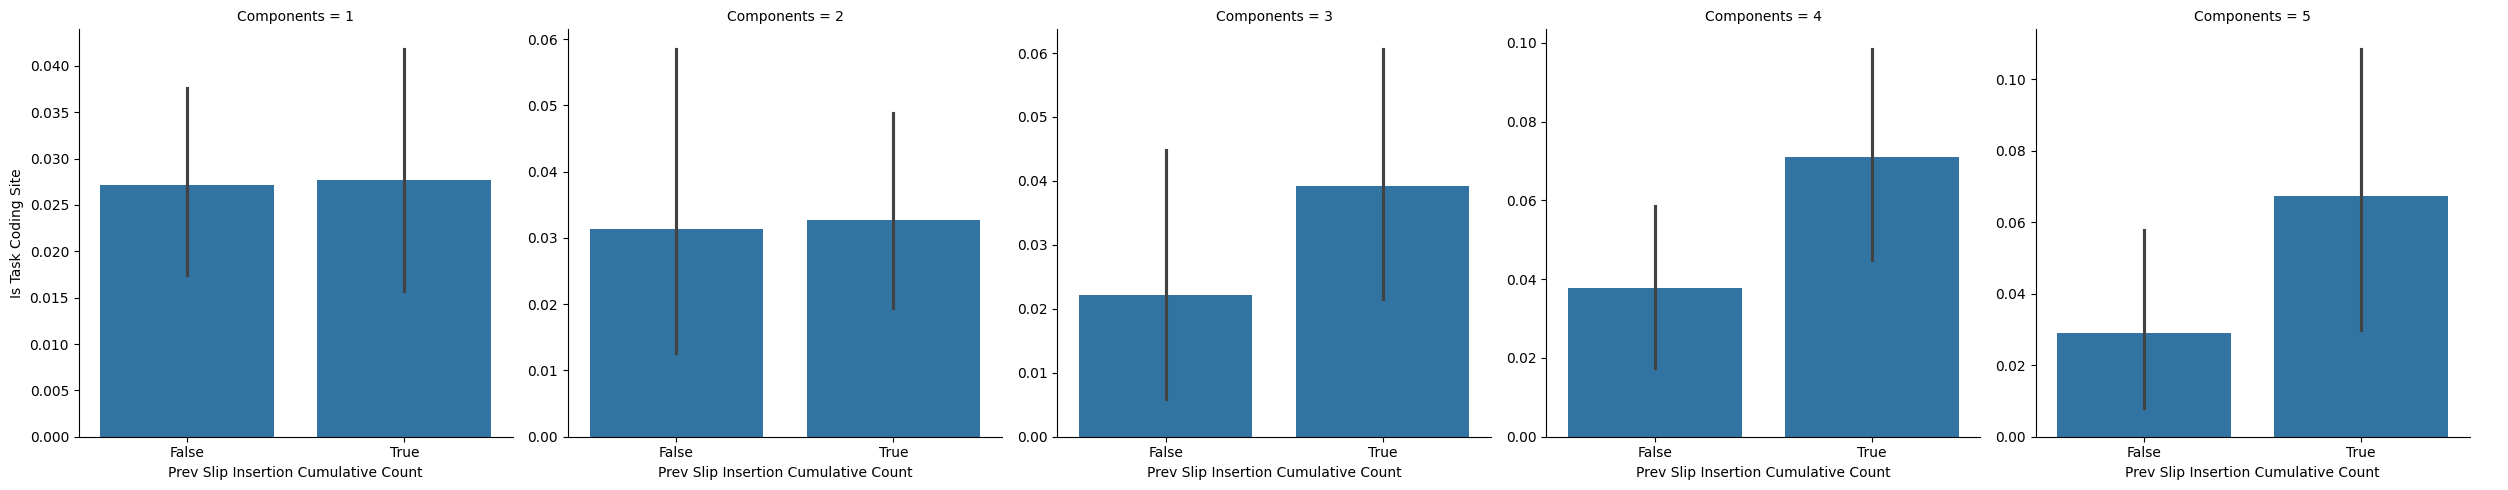

In [13]:
tp.tee(
    sns.catplot,
    data=dff[
        dff["SLIP_INSERTION_BOOL_MASK any"]
    ].astype(
        {"Prev Slip Insertion Cumulative Count": bool},
    ).groupby(
        ["Treatment", "Run ID", "Task", "Prev Slip Insertion Cumulative Count"],
        observed=True,
    ).agg(
        {
            "Is Task Coding Site": "mean",
            "Components": "first",
        },
    ),
    x="Prev Slip Insertion Cumulative Count",
    y="Is Task Coding Site",
    col="Components",
    kind="bar",
    sharey=False,
)


In [14]:
dfy = dff.groupby(
    ["Treatment", "Run ID", "Task"],
    observed=True,
)["Is Task Coding Site"].transform("mean")
print(dfy)

dff["Mean Is Task Coding Site"] = dfy


0        0.048837
1        0.048837
2        0.048837
3        0.048837
4        0.048837
           ...   
81054    0.014888
81055    0.014888
81056    0.014888
81057    0.014888
81058    0.014888
Name: Is Task Coding Site, Length: 81059, dtype: float64


In [15]:
dfp = dff.astype(
    {"Prev Slip Insertion Cumulative Count": bool},
).groupby(
    ["Treatment", "Run ID", "Task", "Prev Slip Insertion Cumulative Count"],
    observed=True,
).agg(
    {
        "Mean Is Task Coding Site": "first",
        "Is Task Coding Site": "mean",
        "Components": "first",
        "SLIP_INSERTION_BOOL_MASK any": "first",
    },
)

dfp["Is Task Coding Site"] /= dfp["Mean Is Task Coding Site"]
dfp = dfp.reset_index()
dfp


,Treatment,Run ID,Task,Prev Slip Insertion Cumulative Count,Mean Is Task Coding Site,Is Task Coding Site,Components,SLIP_INSERTION_BOOL_MASK any
0,Slip-duplicate,run_1590,AND,False,0.048837,1.890110,2,True
1,Slip-duplicate,run_1590,AND,True,0.048837,0.261398,2,True
2,Slip-duplicate,run_1590,ANDNOT,False,0.070234,0.000000,3,False
3,Slip-duplicate,run_1590,ANDNOT,True,0.070234,2.047945,3,False
4,Slip-duplicate,run_1590,EQUALS,False,0.074534,1.585606,5,False
...,...,...,...,...,...,...,...,...
482,Slip-duplicate,run_1619,OR,True,0.119497,1.296516,3,False
483,Slip-duplicate,run_1619,ORNOT,False,0.012579,0.903409,2,False
484,Slip-duplicate,run_1619,ORNOT,True,0.012579,1.119718,2,False
485,Slip-duplicate,run_1619,XOR,False,0.014888,0.000000,4,False


teeplots/density-norm=width+hue=prev-slip-insertion-cumulative-count+kind=violin+slipgain=only+viz=catplot+x=components+y=is-task-coding-site+ext=.pdf
teeplots/density-norm=width+hue=prev-slip-insertion-cumulative-count+kind=violin+slipgain=only+viz=catplot+x=components+y=is-task-coding-site+ext=.png


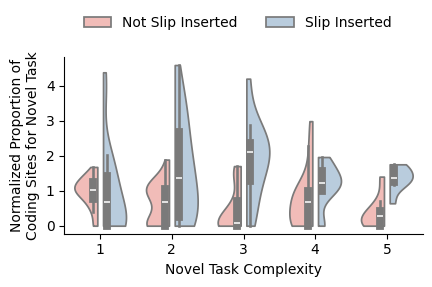

In [16]:
dfp_ = dfp.copy()
dfp_["Prev Slip Insertion Cumulative Count"] = dfp_[
    "Prev Slip Insertion Cumulative Count"
].map(
    {True: "Slip Inserted", False: "Not Slip Inserted"}
)
with tp.teed(
    sns.catplot,
    data=dfp_[
        dfp_["SLIP_INSERTION_BOOL_MASK any"]
    ],
    hue="Prev Slip Insertion Cumulative Count",
    y="Is Task Coding Site",
    x="Components",
    # row="Treatment",
    kind="violin",
    density_norm="width",
    cut=0,
    split=True,
    gap=0.2,
    # notch=True,
    aspect=1.8,
    height=2.5,
    palette="Pastel1",
    teeplot_outattrs={"slipgain": "only"},
    teeplot_outexclude="palette",
) as g:
    ax, = g.axes.flat
    ax.set_ylabel("Normalized Proportion of\nCoding Sites for Novel Task")
    ax.set_xlabel("Novel Task Complexity")
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(.36, 1), ncol=2, title=None, frameon=False,
    )


In [17]:
# Perform Kruskal-Wallis test
kruskal_results = dfp[
    dfp["SLIP_INSERTION_BOOL_MASK any"]
].groupby("Components").apply(
    lambda x: scipy.stats.kruskal(
        x[
            x["Prev Slip Insertion Cumulative Count"]
        ]["Is Task Coding Site"],
        x[
            ~x["Prev Slip Insertion Cumulative Count"]
        ]["Is Task Coding Site"]
    ),
    include_groups=True,
)

# Create a DataFrame to store the results
kruskal_df = pd.DataFrame(
    kruskal_results.tolist(),
    index=kruskal_results.index,
    columns=["H-statistic", "p-value"]
)

print(kruskal_df)
# Calculate means and standard deviations for all groups
group_stats = dfp[
    dfp["SLIP_INSERTION_BOOL_MASK any"]
].groupby(["Components", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()

# Print the group statistics
print(group_stats)
# Calculate group sizes
group_sizes = dfp[
    dfp["SLIP_INSERTION_BOOL_MASK any"]
].groupby(["Components", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')

# Print the group sizes
print(group_sizes)


            H-statistic   p-value
Components                       
1              1.466496  0.225899
2              5.189236  0.022727
3             11.358043  0.000751
4              6.272032  0.012266
5              8.088018  0.004456
   Components  Prev Slip Insertion Cumulative Count      mean       std
0           1                                 False  0.969013  0.436093
1           1                                  True  0.931793  1.227474
2           2                                 False  0.641352  0.594302
3           2                                  True  1.594375  1.407244
4           3                                 False  0.457643  0.639838
5           3                                  True  1.878800  1.110595
6           4                                 False  0.740354  0.844725
7           4                                  True  1.170712  0.608646
8           5                                 False  0.370224  0.479950
9           5                             

/tmp/ipykernel_4110/871174360.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ].groupby("Components").apply(


teeplots/density-norm=width+hue=prev-slip-insertion-cumulative-count+kind=violin+viz=catplot+x=components+y=is-task-coding-site+ext=.pdf
teeplots/density-norm=width+hue=prev-slip-insertion-cumulative-count+kind=violin+viz=catplot+x=components+y=is-task-coding-site+ext=.png


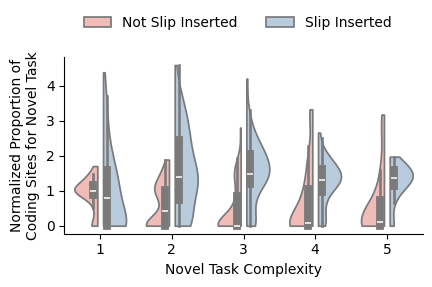

In [18]:
dfp_ = dfp.copy()
dfp_["Prev Slip Insertion Cumulative Count"] = dfp_[
    "Prev Slip Insertion Cumulative Count"
].map(
    {True: "Slip Inserted", False: "Not Slip Inserted"}
)

with tp.teed(
    sns.catplot,
    data=dfp_,
    hue="Prev Slip Insertion Cumulative Count",
    y="Is Task Coding Site",
    x="Components",
    # row="Treatment",
    kind="violin",
    density_norm="width",
    cut=0,
    split=True,
    gap=0.2,
    # notch=True,
    aspect=1.8,
    height=2.5,
    palette="Pastel1",
    teeplot_outexclude="palette",
) as g:
    ax, = g.axes.flat
    ax.set_ylabel("Normalized Proportion of\nCoding Sites for Novel Task")
    ax.set_xlabel("Novel Task Complexity")
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(.36, 1), ncol=2, title=None, frameon=False,
    )


In [19]:
# Perform Kruskal-Wallis test
kruskal_results = dfp.groupby("Components").apply(
    lambda x: scipy.stats.kruskal(
        x[
            x["Prev Slip Insertion Cumulative Count"]
        ]["Is Task Coding Site"],
        x[
            ~x["Prev Slip Insertion Cumulative Count"]
        ]["Is Task Coding Site"]
    )
)

# Create a DataFrame to store the results
kruskal_df = pd.DataFrame(
    kruskal_results.tolist(),
    index=kruskal_results.index,
    columns=["H-statistic", "p-value"]
)

print(kruskal_df)
# Calculate means and standard deviations for all groups
group_stats = dfp.groupby(["Components", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()

# Print the group statistics
print(group_stats)
# Calculate group sizes
group_sizes = dfp.groupby(["Components", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')

# Print the group sizes
print(group_sizes)


            H-statistic       p-value
Components                           
1              1.011820  3.144672e-01
2             22.787798  1.809107e-06
3             33.846753  5.962854e-09
4             15.359894  8.885441e-05
5              9.097744  2.559249e-03
   Components  Prev Slip Insertion Cumulative Count      mean       std
0           1                                 False  0.932088  0.455109
1           1                                  True  1.002025  1.164197
2           2                                 False  0.588566  0.618479
3           2                                  True  1.579974  1.191681
4           3                                 False  0.491481  0.700256
5           3                                  True  1.516115  0.911430
6           4                                 False  0.703793  0.980105
7           4                                  True  1.229158  0.654042
8           5                                 False  0.583674  0.927917
9           5 

/tmp/ipykernel_4110/2825848591.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kruskal_results = dfp.groupby("Components").apply(


          Treatment    Run ID    Task  Prev Slip Insertion Cumulative Count  \
0    Slip-duplicate  run_1590     AND                                 False   
1    Slip-duplicate  run_1590     AND                                  True   
2    Slip-duplicate  run_1590  ANDNOT                                 False   
3    Slip-duplicate  run_1590  ANDNOT                                  True   
4    Slip-duplicate  run_1590  EQUALS                                 False   
..              ...       ...     ...                                   ...   
479  Slip-duplicate  run_1619      OR                                  True   
480  Slip-duplicate  run_1619   ORNOT                                 False   
481  Slip-duplicate  run_1619   ORNOT                                  True   
482  Slip-duplicate  run_1619     XOR                                 False   
483  Slip-duplicate  run_1619     XOR                                  True   

     Mean Is Task Coding Site  Is Task Coding Site 

teeplots/density-norm=width+hue=prev-slip-insertion-cumulative-count+kind=violin+viability=exclude+viz=catplot+x=components+y=is-task-coding-site+ext=.pdf
teeplots/density-norm=width+hue=prev-slip-insertion-cumulative-count+kind=violin+viability=exclude+viz=catplot+x=components+y=is-task-coding-site+ext=.png


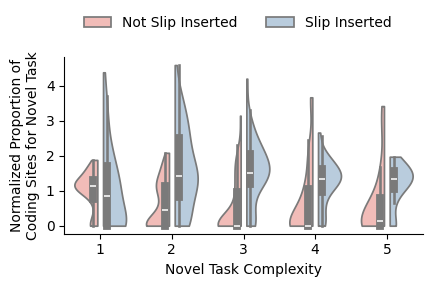

In [20]:
dfpx = dff[
    ~dff["Prev Is Viability Site"]
].astype(
    {"Prev Slip Insertion Cumulative Count": bool},
).groupby(
    ["Treatment", "Run ID", "Task", "Prev Slip Insertion Cumulative Count"],
    observed=True,
).agg(
    {
        "Mean Is Task Coding Site": "first",
        "Is Task Coding Site": "mean",
        "Components": "first",
        "SLIP_INSERTION_BOOL_MASK any": "first",
    },
)

dfpx["Is Task Coding Site"] /= dfpx["Mean Is Task Coding Site"]
dfpx = dfpx.reset_index()
print(dfpx)

dfpx_ = dfpx.copy()
dfpx_["Prev Slip Insertion Cumulative Count"] = dfpx_[
    "Prev Slip Insertion Cumulative Count"
].map(
    {True: "Slip Inserted", False: "Not Slip Inserted"}
)

with tp.teed(
    sns.catplot,
    data=dfpx_,
    hue="Prev Slip Insertion Cumulative Count",
    y="Is Task Coding Site",
    x="Components",
    # row="Treatment",
    kind="violin",
    density_norm="width",
    cut=0,
    split=True,
    gap=0.2,
    # notch=True,
    aspect=1.8,
    height=2.5,
    palette="Pastel1",
    teeplot_outattrs={"viability": "exclude"},
    teeplot_outexclude="palette",
) as g:
    ax, = g.axes.flat
    ax.set_ylabel("Normalized Proportion of\nCoding Sites for Novel Task")
    ax.set_xlabel("Novel Task Complexity")
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(.36, 1), ncol=2, title=None, frameon=False,
    )


In [21]:
# Perform Kruskal-Wallis test
kruskal_results = dfpx.groupby("Components").apply(
    lambda x: scipy.stats.kruskal(
        x[
            x["Prev Slip Insertion Cumulative Count"]
        ]["Is Task Coding Site"],
        x[
            ~x["Prev Slip Insertion Cumulative Count"]
        ]["Is Task Coding Site"]
    )
)

# Create a DataFrame to store the results
kruskal_df = pd.DataFrame(
    kruskal_results.tolist(),
    index=kruskal_results.index,
    columns=["H-statistic", "p-value"]
)

print(kruskal_df)
# Calculate means and standard deviations for all groups
group_stats = dfpx.groupby(["Components", "Prev Slip Insertion Cumulative Count"])["Is Task Coding Site"].agg(["mean", "std"]).reset_index()

# Print the group statistics
print(group_stats)
# Calculate group sizes
group_sizes = dfpx.groupby(["Components", "Prev Slip Insertion Cumulative Count"]).size().reset_index(name='size')

# Print the group sizes
print(group_sizes)


            H-statistic       p-value
Components                           
1              0.852615  3.558135e-01
2             22.275265  2.362300e-06
3             30.283198  3.733461e-08
4             15.404583  8.677756e-05
5              7.425000  6.432383e-03
   Components  Prev Slip Insertion Cumulative Count      mean       std
0           1                                 False  1.021203  0.539732
1           1                                  True  1.049763  1.171343
2           2                                 False  0.633574  0.681144
3           2                                  True  1.621013  1.183828
4           3                                 False  0.546084  0.783429
5           3                                  True  1.530474  0.918999
6           4                                 False  0.700892  1.021518
7           4                                  True  1.234347  0.656445
8           5                                 False  0.616704  0.989464
9           5 

/tmp/ipykernel_4110/2463430842.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kruskal_results = dfpx.groupby("Components").apply(


teeplots/col=components+kind=hist+stat=count+viz=displot+x=prev-slip-insertion-cumulative-count+ext=.pdf


teeplots/col=components+kind=hist+stat=count+viz=displot+x=prev-slip-insertion-cumulative-count+ext=.png


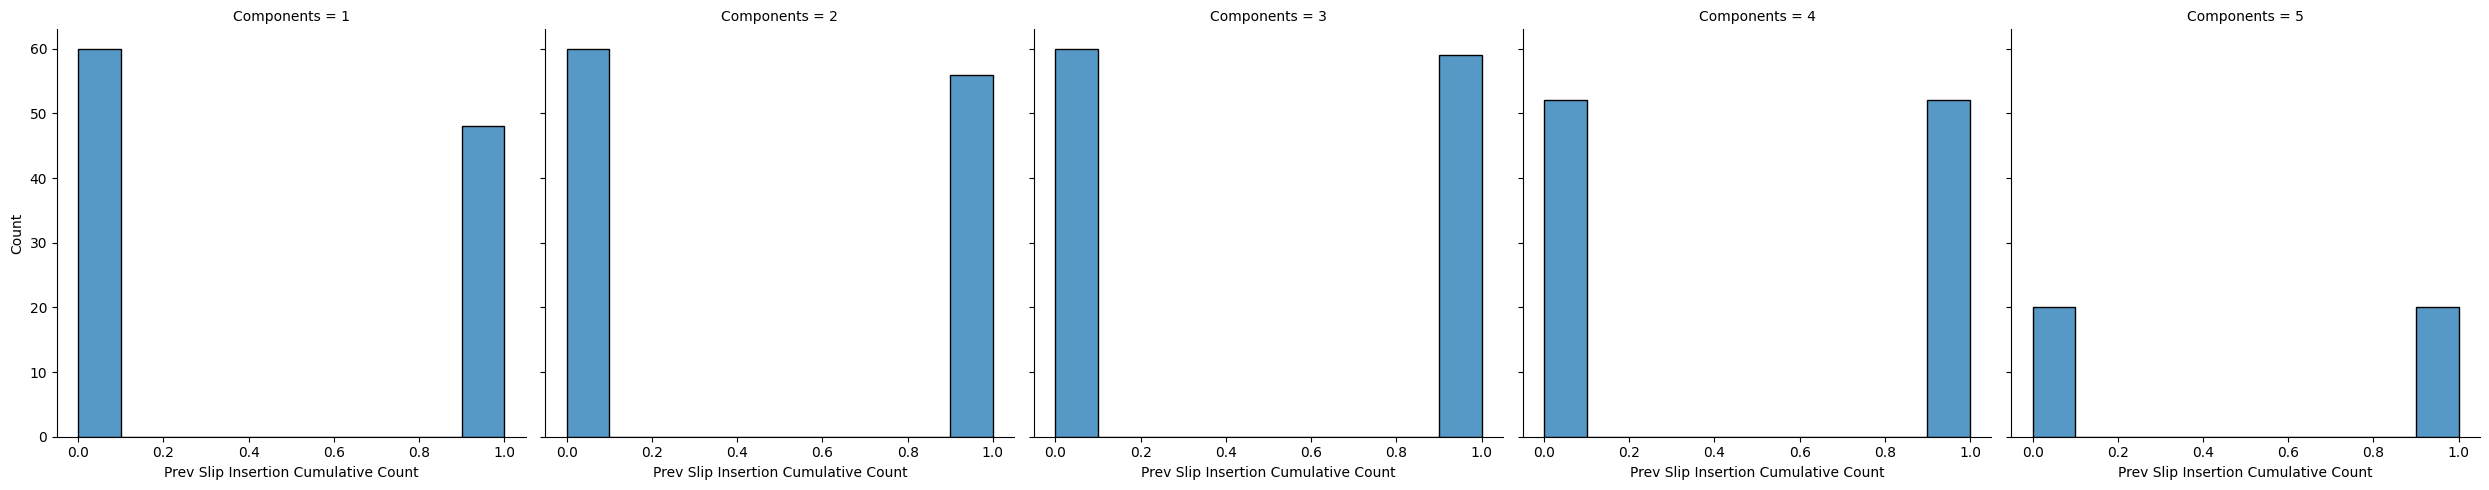

In [22]:
tp.tee(
    sns.displot,
    data=dff.astype(
        {"Prev Slip Insertion Cumulative Count": bool},
    ).groupby(
        ["Treatment", "Run ID", "Task", "Prev Slip Insertion Cumulative Count"],
        observed=True,
    ).agg(
        {
            "Is Task Coding Site": "mean",
            "Components": "first",
            "Task": "first",
        },
    ),
    x="Prev Slip Insertion Cumulative Count",
    col="Components",
    # row="Treatment",
    kind="hist",
    stat="count",
)


teeplots/hue=is-task-coding-site+kind=swarm+viz=catplot+x=components+y=prev-slip-insertion-cumulative-count+ext=.pdf


teeplots/hue=is-task-coding-site+kind=swarm+viz=catplot+x=components+y=prev-slip-insertion-cumulative-count+ext=.png


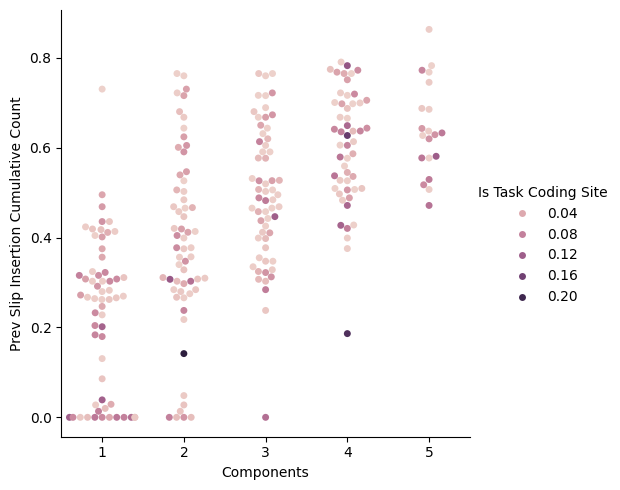

In [23]:
tp.tee(
    sns.catplot,
    data=dff.astype(
        {"Prev Slip Insertion Cumulative Count": bool},
    ).groupby(
        ["Treatment", "Run ID", "Task"],
        observed=True,
    ).agg(
        {
            "Prev Slip Insertion Cumulative Count": "mean",
            "Is Task Coding Site": "mean",
            "Components": "first",
            "Task": "first",
        },
    ),
    y="Prev Slip Insertion Cumulative Count",
    x="Components",
    hue="Is Task Coding Site",
    kind="swarm",
)


teeplots/hue=prev-slip-insertion-cumulative-count+kind=hist+multiple=fill+viz=displot+x=components+ext=.pdf
teeplots/hue=prev-slip-insertion-cumulative-count+kind=hist+multiple=fill+viz=displot+x=components+ext=.png


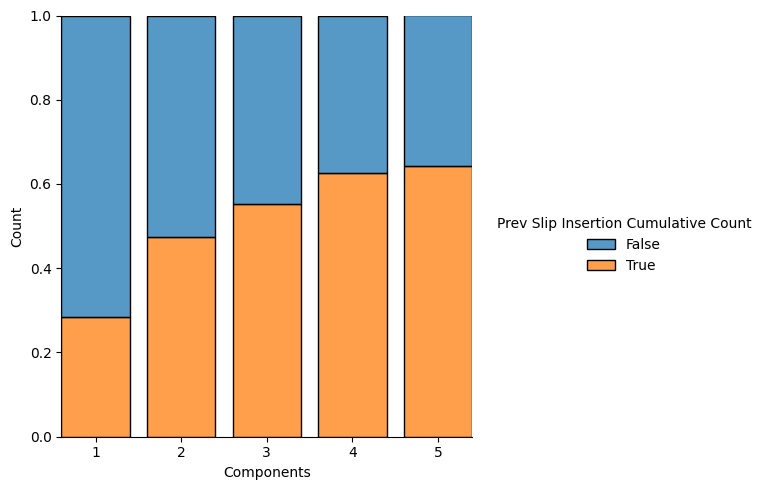

teeplots/hue=prev-slip-insertion-cumulative-count+kind=hist+multiple=stack+viz=displot+x=components+ext=.pdf
teeplots/hue=prev-slip-insertion-cumulative-count+kind=hist+multiple=stack+viz=displot+x=components+ext=.png


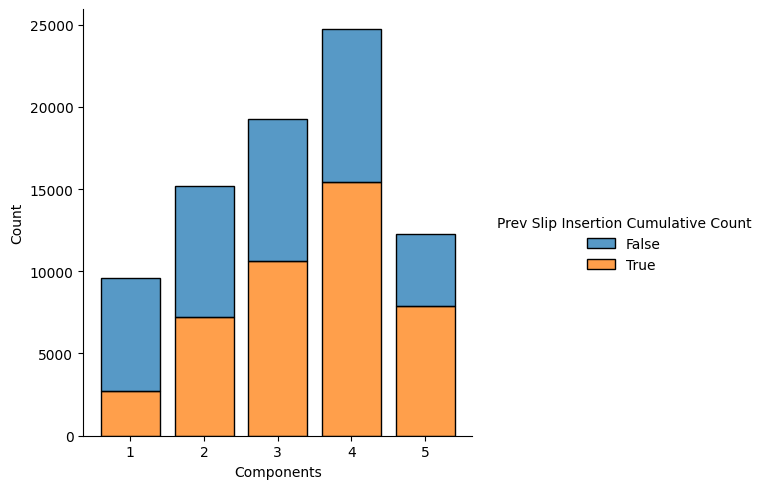

In [24]:
for multiple in "fill", "stack":
    tp.tee(
        sns.displot,
        data=dff.astype(
            {
                "Components": "category",
                "Prev Slip Insertion Cumulative Count": bool
            },
        ),
        hue="Prev Slip Insertion Cumulative Count",
        x="Components",
        kind="hist",
        multiple=multiple,
        shrink=0.8,
    )


teeplots/col=components+kind=bar+viz=catplot+x=prev-is-viability-site+y=is-task-coding-site+ext=.pdf


teeplots/col=components+kind=bar+viz=catplot+x=prev-is-viability-site+y=is-task-coding-site+ext=.png


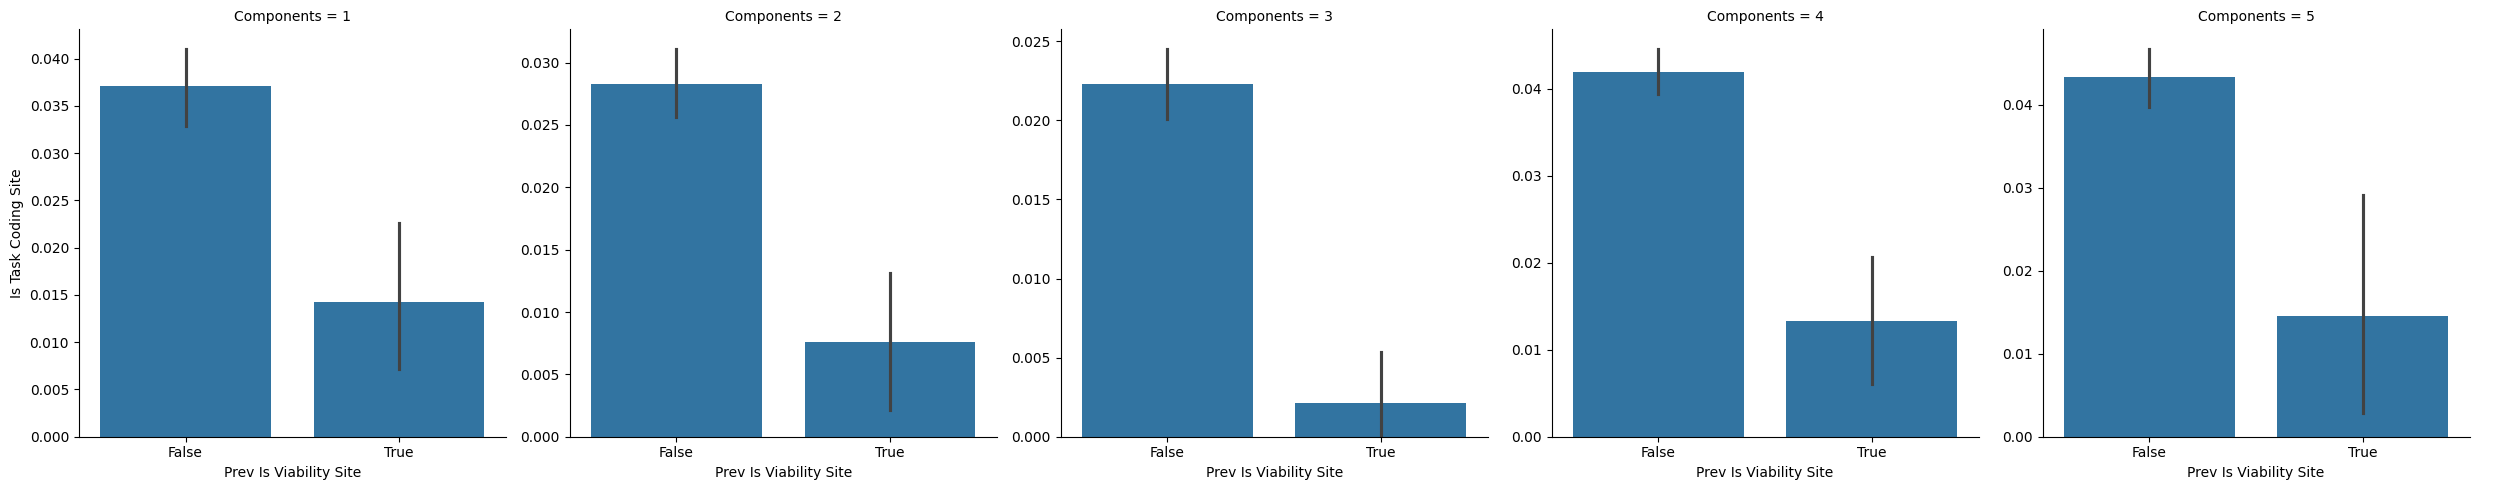

In [25]:
tp.tee(
    sns.catplot,
    data=dff.astype(
        {"Prev Is Viability Site": bool}
    ),
    x="Prev Is Viability Site",
    y="Is Task Coding Site",
    col="Components",
    kind="bar",
    sharey=False,
)


teeplots/col=components+kind=bar+viz=catplot+x=prev-is-viability-site+y=prev-slip-insertion-cumulative-count+ext=.pdf


teeplots/col=components+kind=bar+viz=catplot+x=prev-is-viability-site+y=prev-slip-insertion-cumulative-count+ext=.png


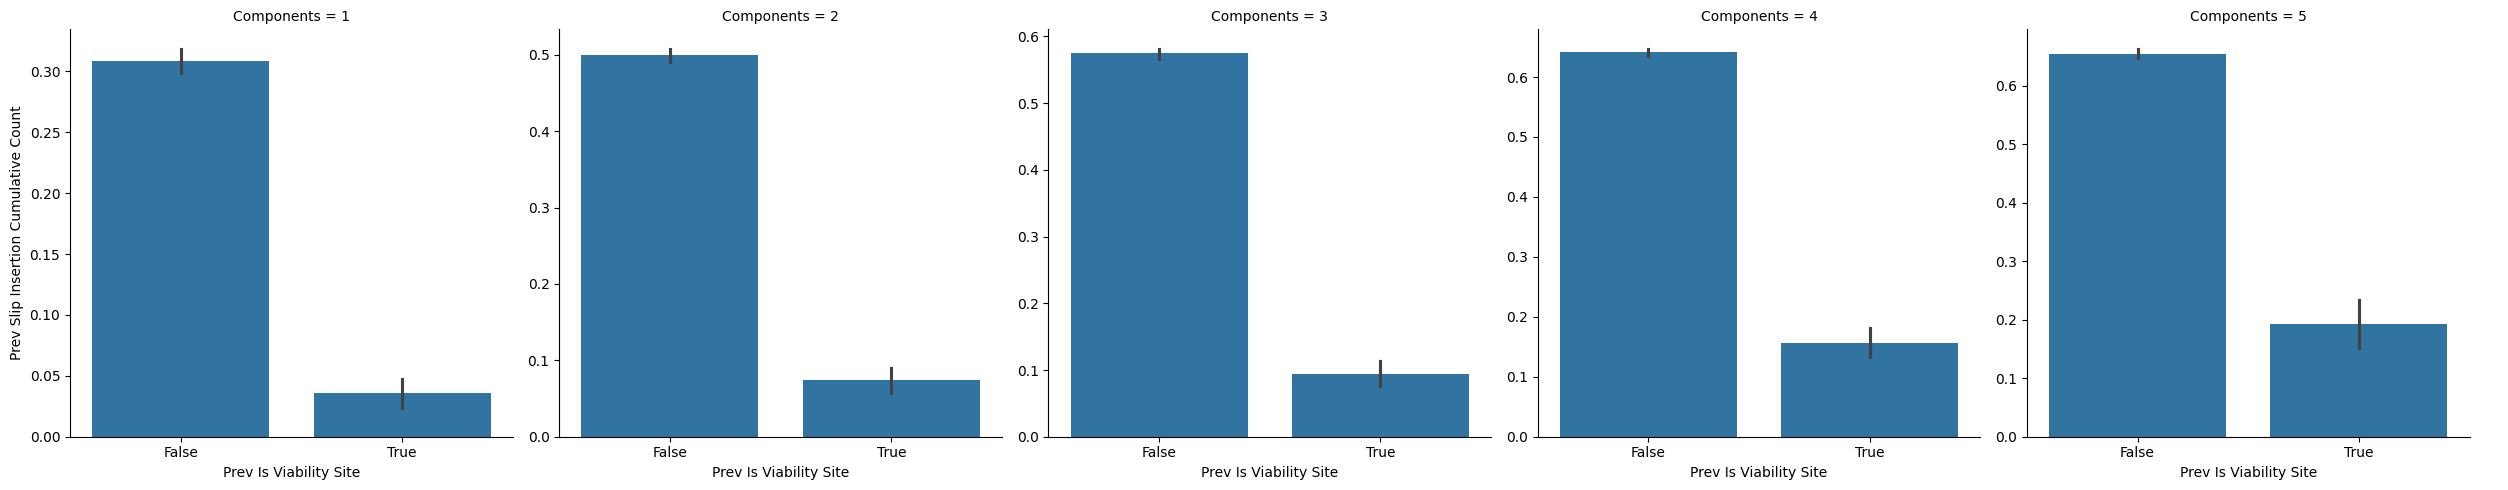

In [26]:
tp.tee(
    sns.catplot,
    data=dff.astype(
        {"Prev Slip Insertion Cumulative Count": bool}
    ),
    x="Prev Is Viability Site",
    y="Prev Slip Insertion Cumulative Count",
    col="Components",
    kind="bar",
    sharey=False,
)


teeplots/col=components+kind=bar+viz=catplot+x=prev-codes-for-tasks+y=is-task-coding-site+ext=.pdf


teeplots/col=components+kind=bar+viz=catplot+x=prev-codes-for-tasks+y=is-task-coding-site+ext=.png


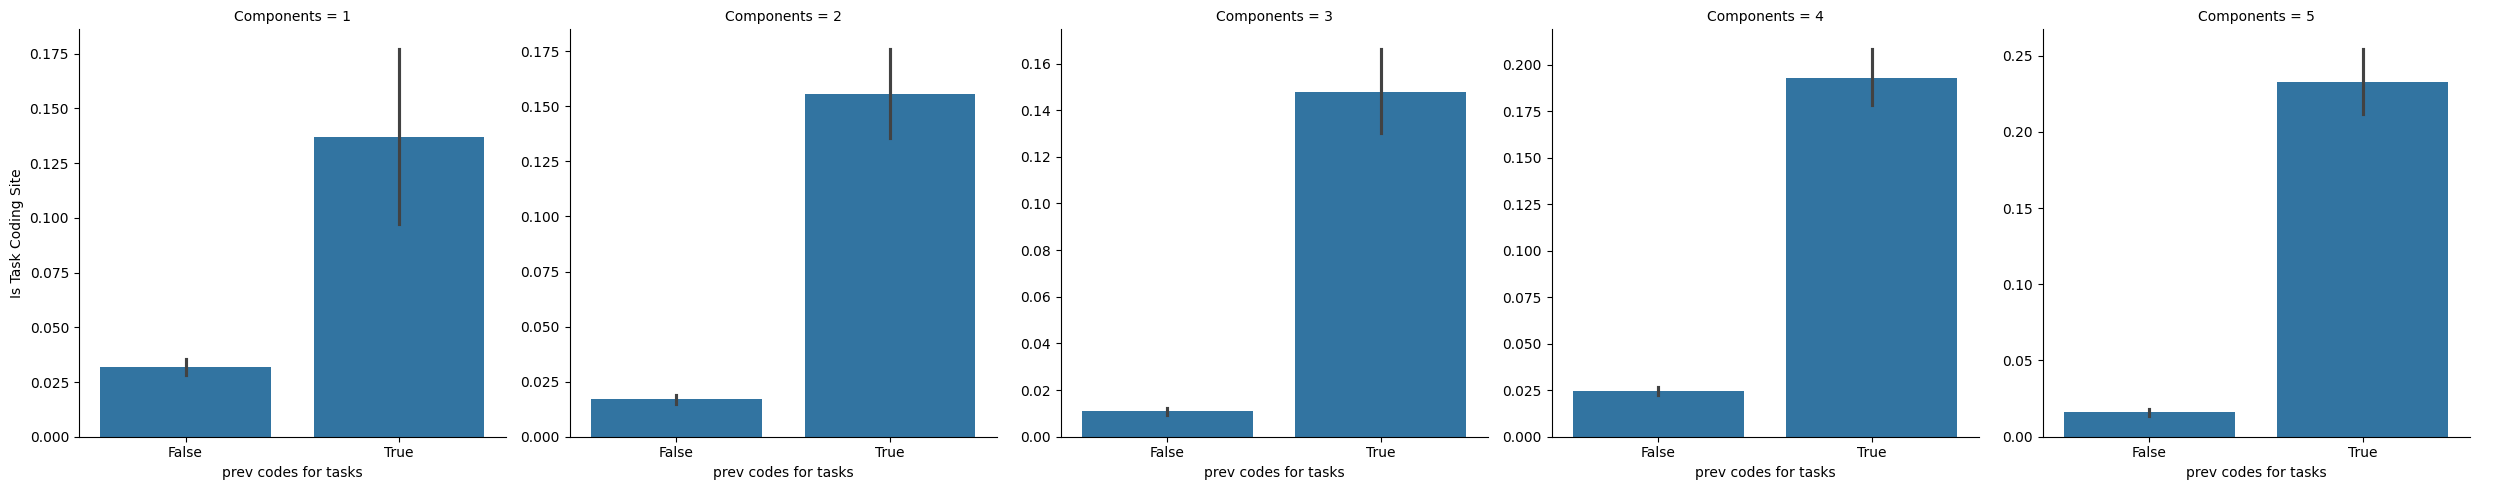

In [27]:
tp.tee(
    sns.catplot,
    data=dff.astype(
        {"Prev Slip Insertion Cumulative Count": bool}
    ),
    x="prev codes for tasks",
    y="Is Task Coding Site",
    col="Components",
    kind="bar",
    sharey=False,
)


teeplots/col=components+kind=bar+viz=catplot+x=prev-slip-insertion-cumulative-count+y=prev-codes-for-tasks+ext=.pdf


teeplots/col=components+kind=bar+viz=catplot+x=prev-slip-insertion-cumulative-count+y=prev-codes-for-tasks+ext=.png


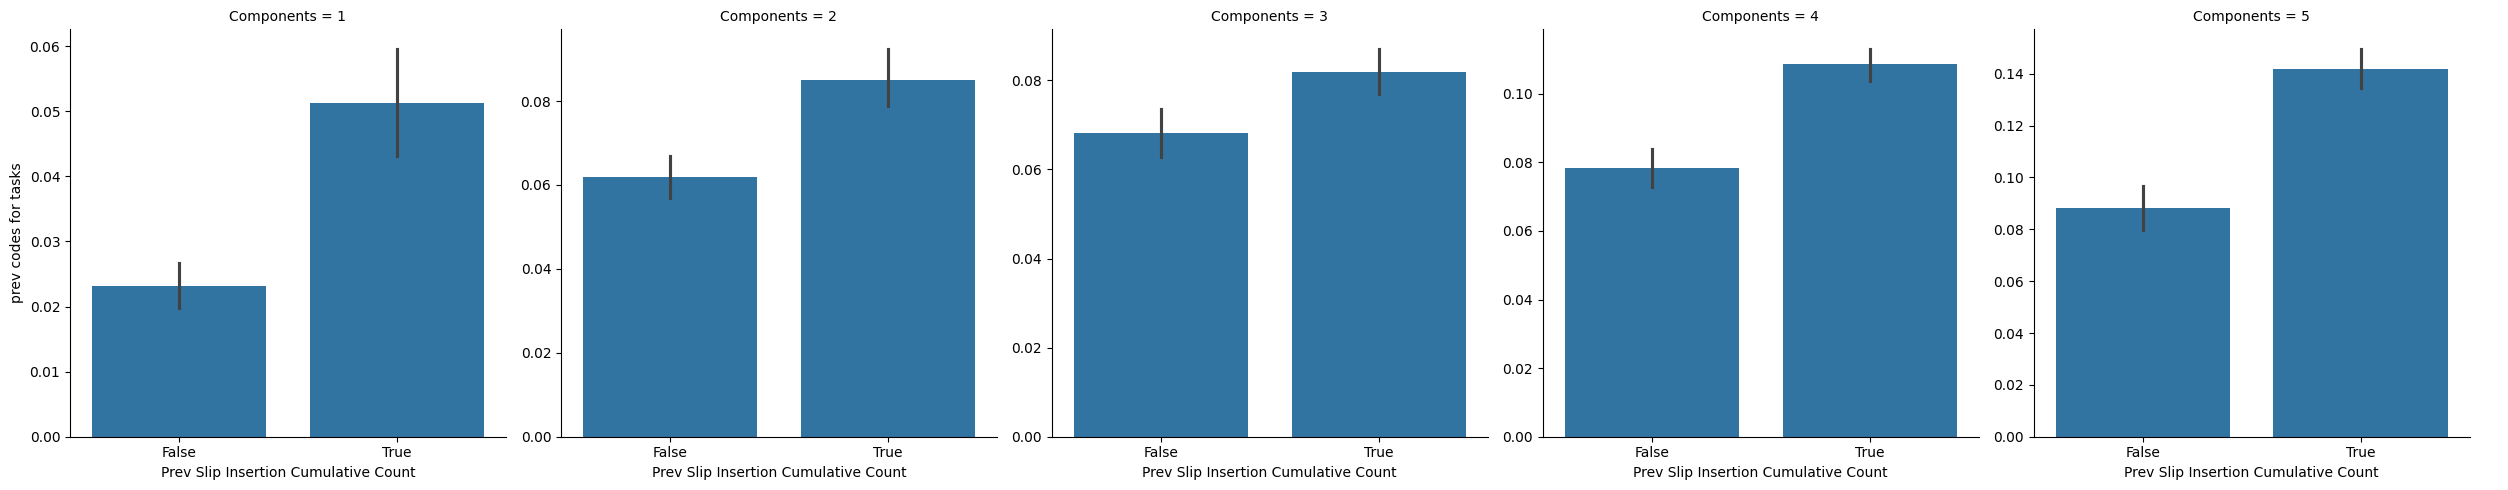

In [28]:
tp.tee(
    sns.catplot,
    data=dff.astype(
        {"Prev Slip Insertion Cumulative Count": bool}
    ),
    x="Prev Slip Insertion Cumulative Count",
    y="prev codes for tasks",
    col="Components",
    kind="bar",
    sharey=False,
)


teeplots/col=components+kind=bar+viz=catplot+x=slip-insertion-bool-mask+y=is-task-coding-site+ext=.pdf


teeplots/col=components+kind=bar+viz=catplot+x=slip-insertion-bool-mask+y=is-task-coding-site+ext=.png


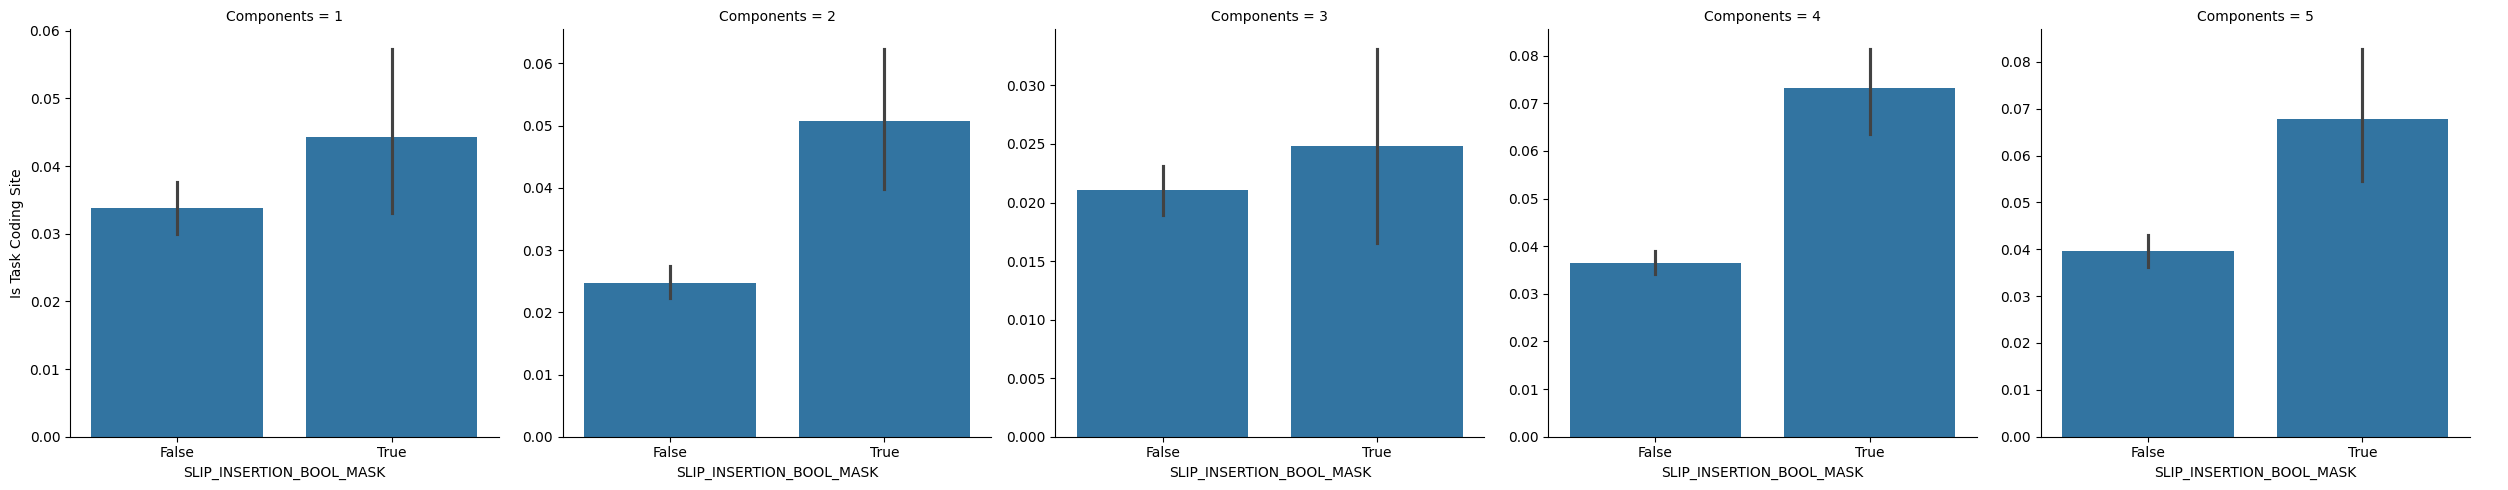

In [29]:
tp.tee(
    sns.catplot,
    data=dff.astype(
        {"Prev Slip Insertion Cumulative Count": bool}
    ),
    x="SLIP_INSERTION_BOOL_MASK",
    y="Is Task Coding Site",
    col="Components",
    kind="bar",
    sharey=False,
)


teeplots/col=components+hue=prev-codes-for-num-tasks+kind=hist+multiple=fill+row=treatment+viz=displot+x=is-task-coding-site+ext=.pdf


teeplots/col=components+hue=prev-codes-for-num-tasks+kind=hist+multiple=fill+row=treatment+viz=displot+x=is-task-coding-site+ext=.png


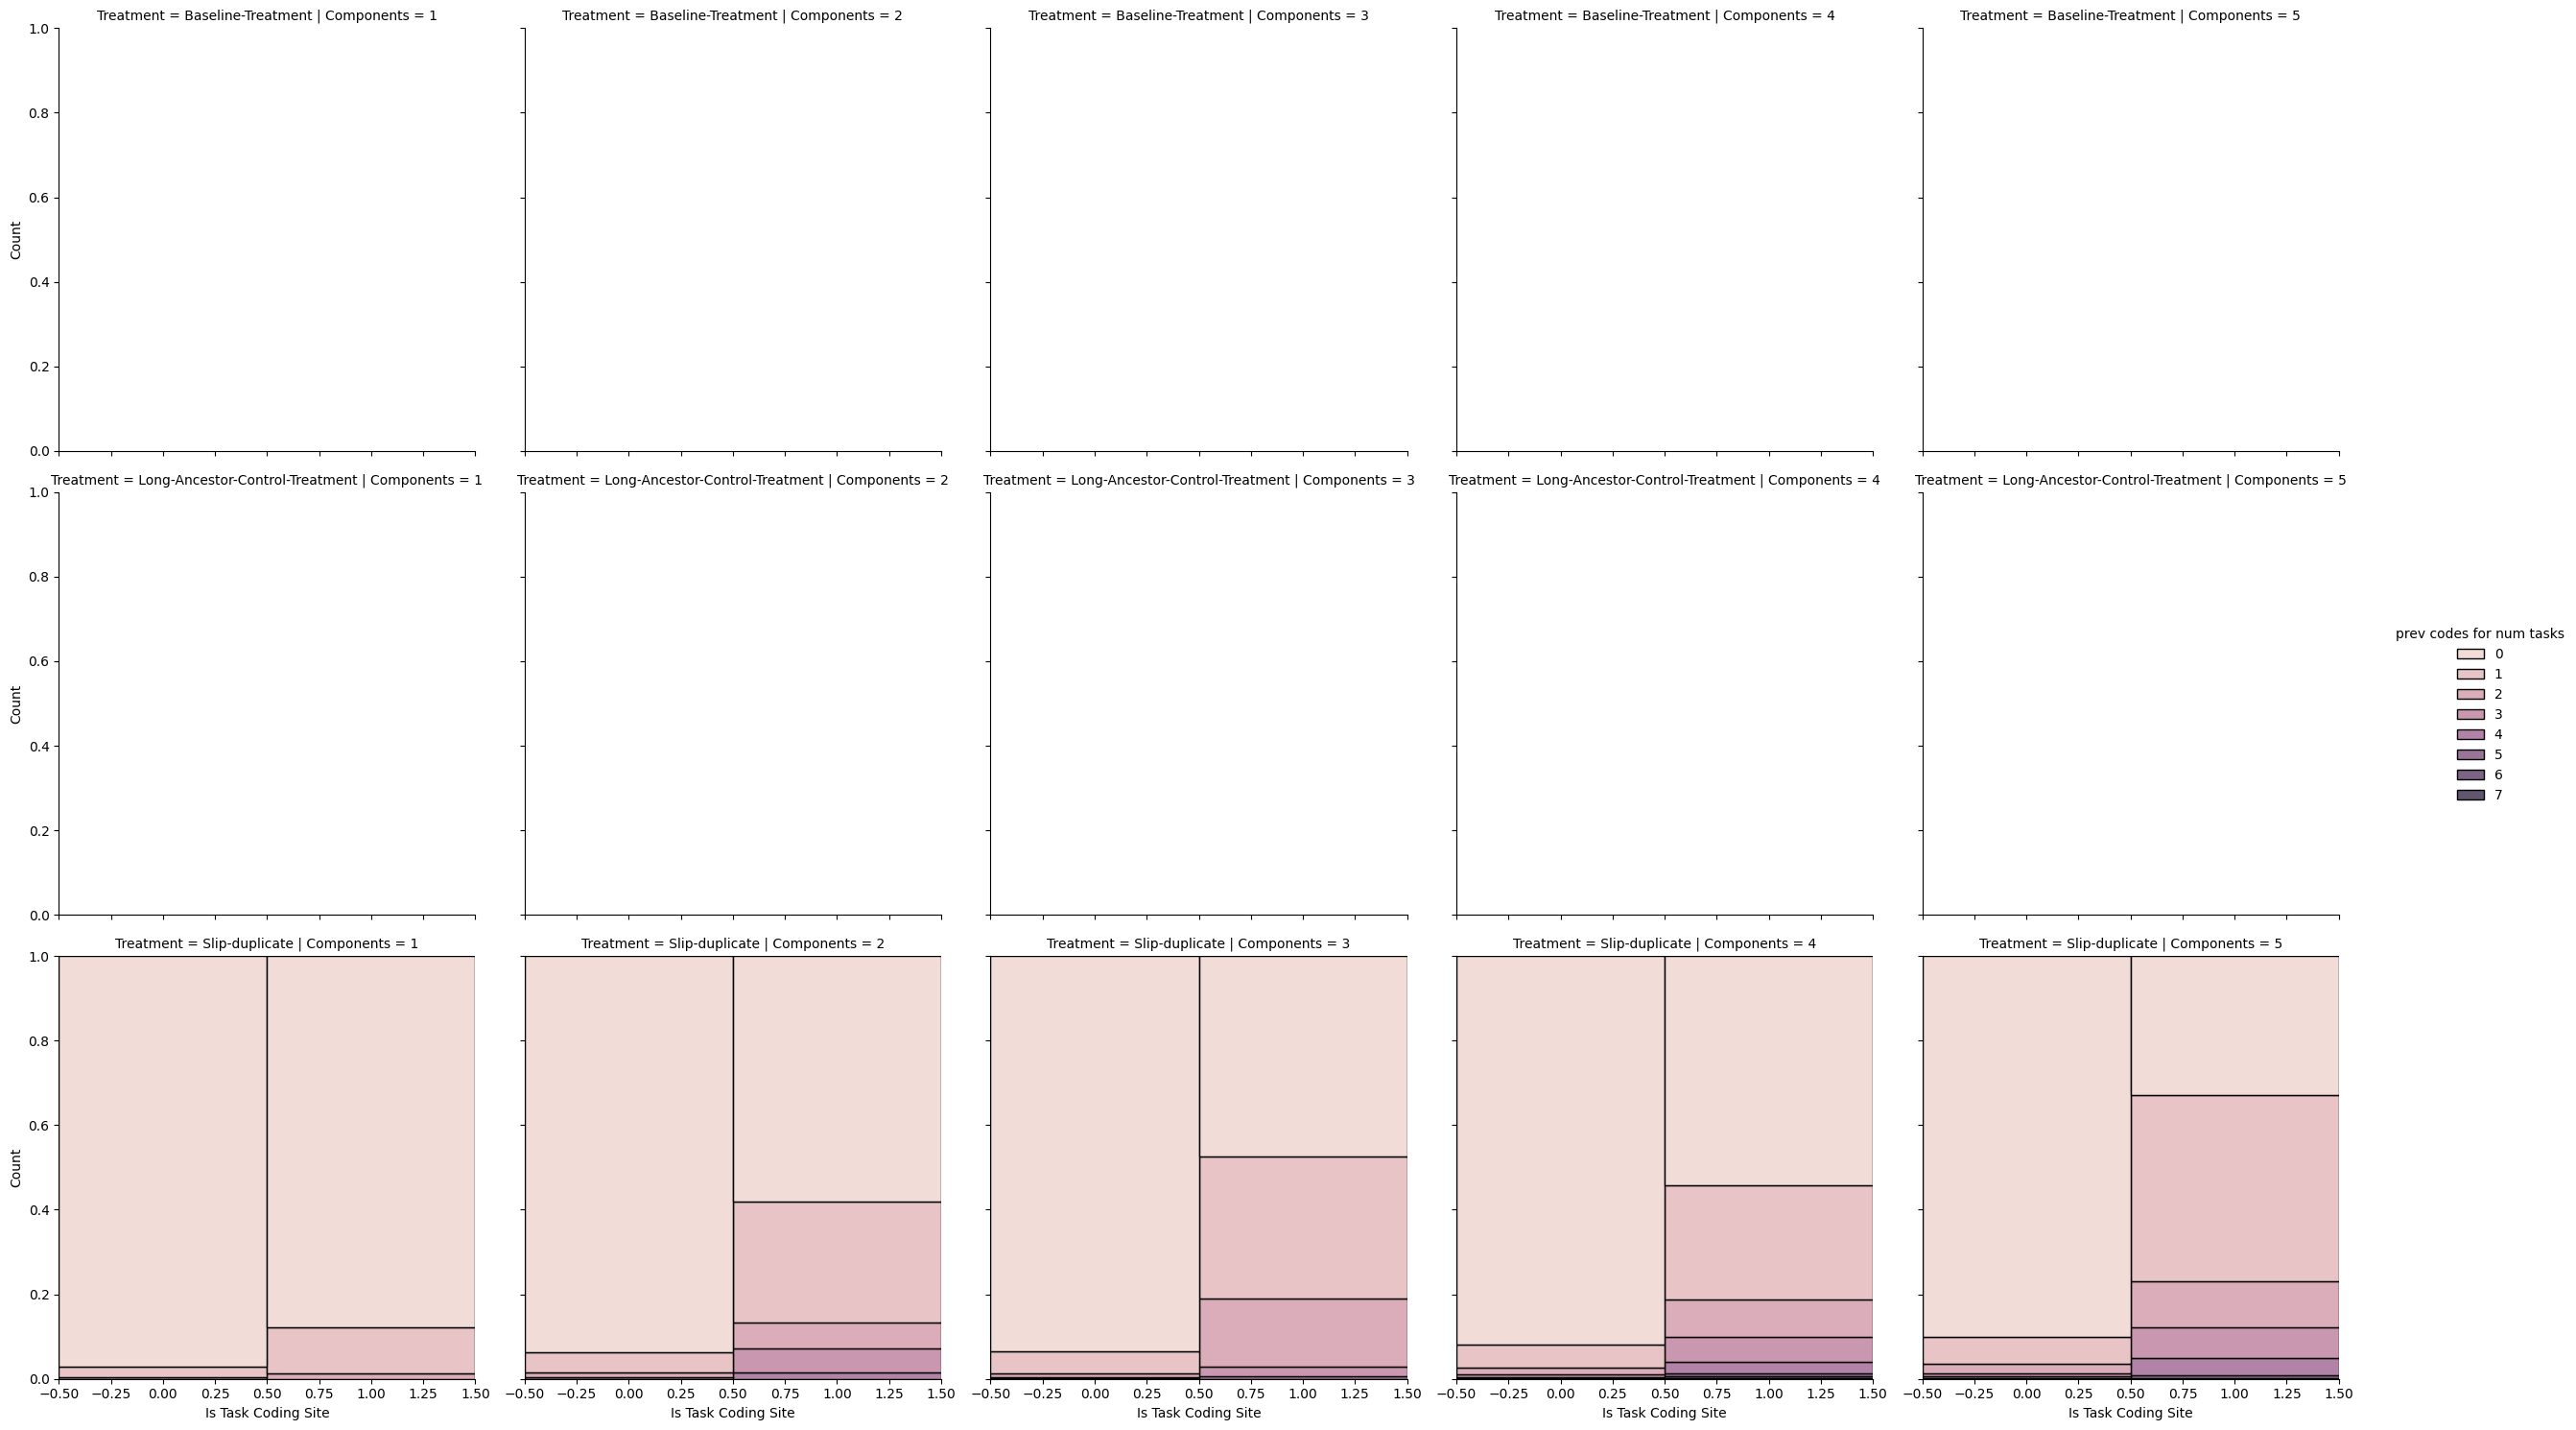

In [30]:
tp.tee(
    sns.displot,
    data=dff.astype(
        {"Is Task Coding Site": "category", "Components": "category"}
    ),
    multiple="fill",
    x="Is Task Coding Site",
    col="Components",
    kind="hist",
    hue="prev codes for num tasks",
    row="Treatment",
)


teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-codes-for-tasks+ext=.pdf
teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-codes-for-tasks+ext=.png


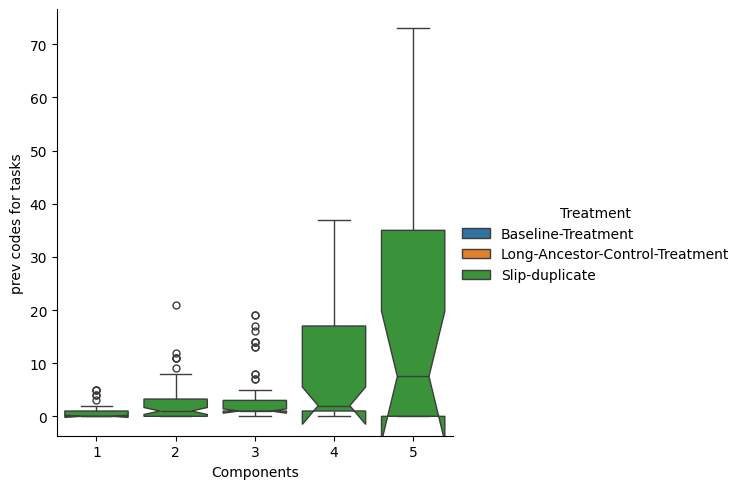

In [31]:
tp.tee(
    sns.catplot,
    data=dff[
        dff["Is Task Coding Site"]
    ].groupby(
        ["Lineage Generation Index", "Treatment", "Run ID", "Components"],
        observed=True,
    )['prev codes for tasks'].sum().reset_index(),
    hue="Treatment",
    y="prev codes for tasks",
    x="Components",
    kind="box",
    notch=True,
)


teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-coded-for-tasks+ext=.pdf
teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-coded-for-tasks+ext=.png


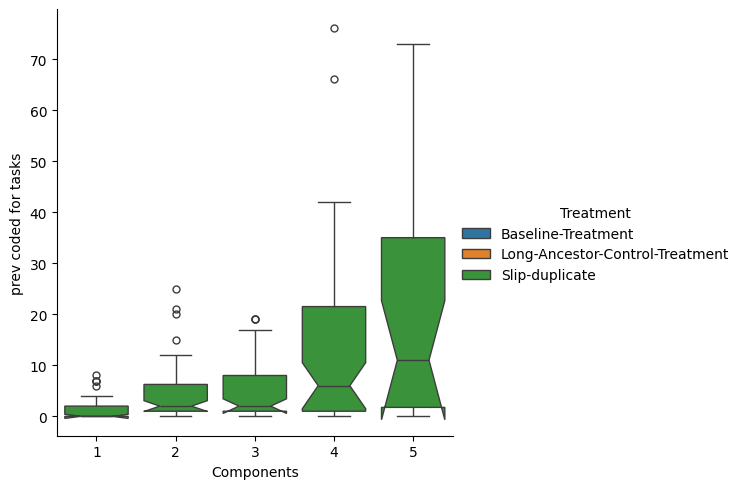

In [32]:
tp.tee(
    sns.catplot,
    data=dff[
        dff["Is Task Coding Site"]
    ].groupby(
        ["Lineage Generation Index", "Treatment", "Run ID", "Components"],
        observed=True,
    )['prev coded for tasks'].sum().reset_index(),
    hue="Treatment",
    y="prev coded for tasks",
    x="Components",
    kind="box",
    notch=True,
)


/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-codes-for-tasks+ext=.pdf, overwriting it
  warnings.warn(
/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-codes-for-tasks+ext=.png, overwriting it
  warnings.warn(


teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-codes-for-tasks+ext=.pdf
teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-codes-for-tasks+ext=.png


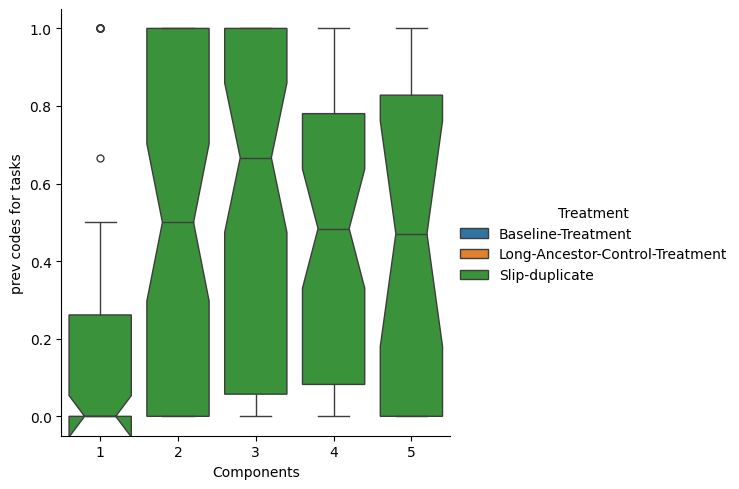

In [33]:
tp.tee(
    sns.catplot,
    data=dff[
        dff["Is Task Coding Site"]
    ].groupby(
        ["Lineage Generation Index", "Treatment", "Run ID", "Components"],
        observed=True,
    )['prev codes for tasks'].mean().reset_index(),
    hue="Treatment",
    y="prev codes for tasks",
    x="Components",
    kind="box",
    notch=True,
)


/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-coded-for-tasks+ext=.pdf, overwriting it
  warnings.warn(
/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-coded-for-tasks+ext=.png, overwriting it
  warnings.warn(


teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-coded-for-tasks+ext=.pdf
teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=prev-coded-for-tasks+ext=.png


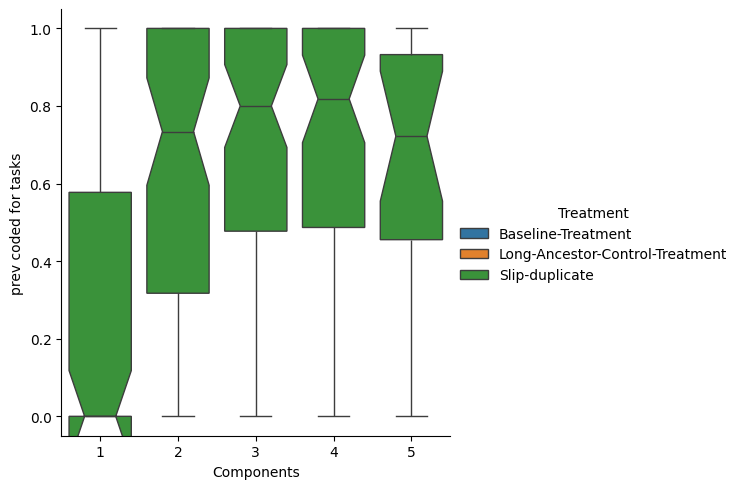

In [34]:
tp.tee(
    sns.catplot,
    data=dff[
        dff["Is Task Coding Site"]
    ].groupby(
        ["Lineage Generation Index", "Treatment", "Run ID", "Components"],
        observed=True,
    )['prev coded for tasks'].mean().reset_index(),
    hue="Treatment",
    y="prev coded for tasks",
    x="Components",
    kind="box",
    notch=True,
)


teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=one+ext=.pdf
teeplots/hue=treatment+kind=box+viz=catplot+x=components+y=one+ext=.png


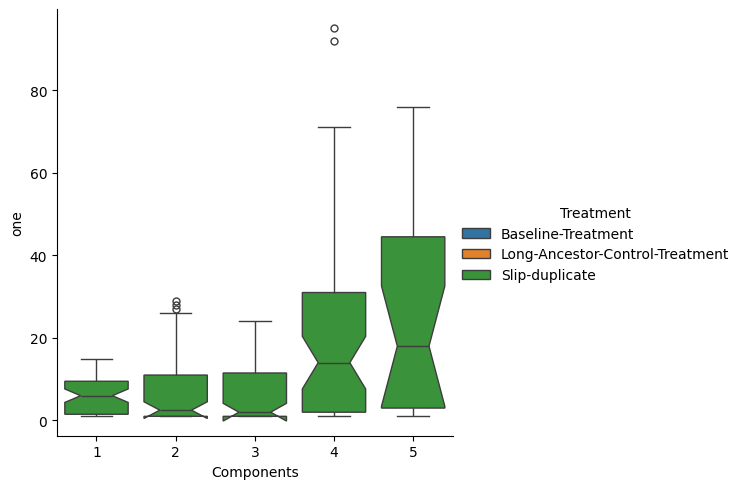

In [35]:
dff["one"] = 1
tp.tee(
    sns.catplot,
    data=dff[
        dff["Is Task Coding Site"]
    ].groupby(
        ["Lineage Generation Index", "Treatment", "Run ID", "Components"],
        observed=True,
    )['one'].sum().reset_index(),
    hue="Treatment",
    y="one",
    x="Components",
    kind="box",
    notch=True,
)
